<a href="https://colab.research.google.com/github/khalidpark/whitepaper-DeepLearning/blob/main/deep_learning_whitepaper_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### 1. 기본 오토 인코더
<img src="https://www.tensorflow.org/tutorials/generative/images/intro_autoencoder_result.png"/>
이미지를 64 차원 잠재 벡터로 압축하는 가장 간단한 형태의 `encoder`와 잠재 공간에서 원본 이미지를 재구성하는 `decoder`라는 두 개의 Dense 레이어로 구성된 모델입니다. 

모델을 정의하려면 [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)를 사용하세요.

### 데이터 세트로드
시작하려면 Fashion MNIST dataset을 이용하여 오토인코더를 학습합니다. 

이 데이터 세트의 각 이미지는 28x28 픽셀입니다.

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [3]:
# Code영역의 벡터(= Latent vector)의 수 정의
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
# decoded된 데이터를 output으로 설정함
autoencoder = Autoencoder(latent_dim) 

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

`x_train`을 입력 및 대상으로 사용하여 모델을 훈련시킵니다. 

`encoder`는 데이터 세트를 784(28x28) 차원에서 latent 공간으로 압축하는 방법을 배우고 

`decoder`는 원본 이미지를 재구성하는 방법을 배웁니다.

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0241 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0102 - val_loss: 0.0100
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.008

학습된 모델을 이용하여 테스트 세트의 이미지를 인코딩 및 디코딩하여 모델을 테스트합니다.

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

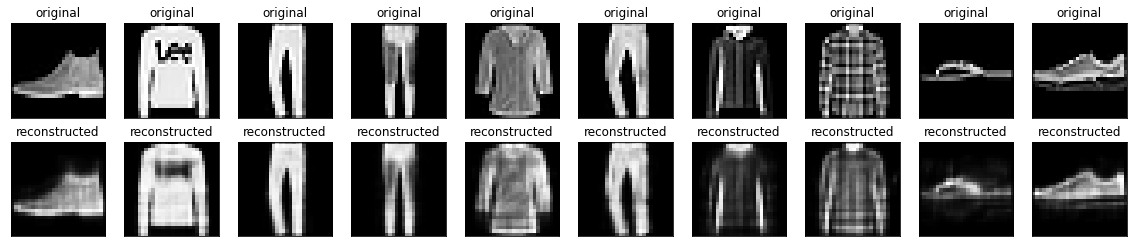

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()



---



# 실습 2



### 노이즈 제거용 오토인코더


<img src="https://www.tensorflow.org/tutorials/generative/images/image_denoise_fmnist_results.png" />

오토인코더는 이미지에서 노이즈를 제거하도록 훈련 될 수도 있습니다. 다음 섹션에서는 각 이미지에 임의의 노이즈를 적용하여 Fashion MNIST 데이터 세트의 노이즈 버전을 생성합니다. 그런 다음 잡음이있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 사용하여 오토 인코더를 훈련합니다.

이전에 수정 한 내용을 생략하기 위해 데이터 세트를 다시 가져 오겠습니다.

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


이미지에 random noise 를 만들어 더해줍니다.

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈가 더해진 이미지를 시각화해보면 다음과 같습니다.

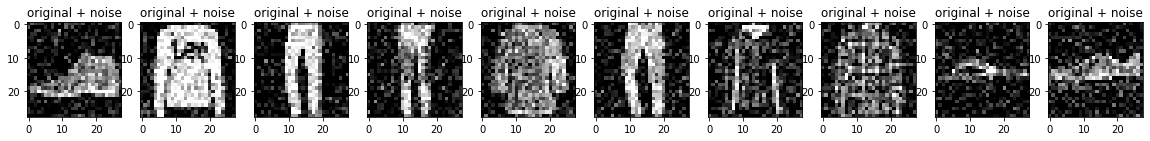

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### convolutional autoencoder

이번 예제는 같은 원리르 갖지만, 가중치의 형태를 CNN형태로 가져옵니다. 

[Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) 레이어를 `encoder`로 사용하고, 반대로 `decoder`로는 [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) 를 사용하는 구조입니다.

In [12]:
# CNN의 형태를 갖는 autoencoder 코드
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0162 - val_loss: 0.0095
Epoch 2/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 3/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0077 - val_loss: 0.0074
Epoch 4/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 5/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 6/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 7/10
1875/1875 [==============================] - 76s 41ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 8/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 77s 41m

인코더 구조의 summary를 살펴 보겠습니다. 

이미지가 28x28에서 7x7로 어떻게 다운 샘플링되는지 확인하십시오.

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


디코더의 구조입니다.

In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


이 모델로 이미지가 어떻게 변환되는 지 확인해보겠습니다.

In [19]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

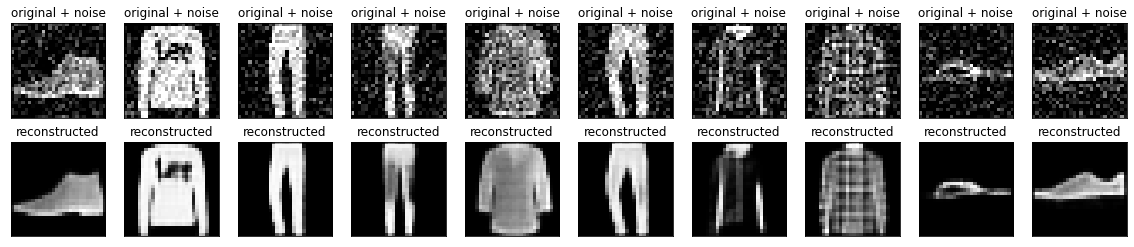

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



---

